# **Using Deep Convolutional Generative Adversarial Networks (DCGANs) to Generate Realistic-looking (but fake) Images of Clothing using the FashionMNIST Dataset**

## **0 Import Necessary Packages**

In [ ]:
import tensorflow        as     tf
from   tensorflow.keras  import layers
from   keras             import preprocessing
from   keras.models      import Sequential
from   keras.layers      import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
import pandas            as     pd
import numpy             as     np
import matplotlib.pyplot as     plt
from   IPython           import display
import os
import glob
import imageio
import PIL
import time
tf.config.run_functions_eagerly(True)

## **1 Load and Prepare the FashionMNIST Dataset**

The FashionMNIST dataset is being used to train our DCGAN. Images were obtained through TensorFlow and are grayscale and size $(28\times28)$.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **2 Defining our DCGAN Architectures**

### **2.1 The Generator Model**

Our generator architecture will be essentially the reverse of the discriminator architecture. 

In this model
* there is a dense layer that takes a Gaussian noise vector of length 100 and maps it to a vector of sixe $7 \times 7 \times 256$. 
* 4 convolutional Layers will follow
  * $256 × 7 × 7$
    * Batch Normalization (BN)
    * Leaky ReLU with slope 0.3
  * $128 × 7 × 7$
    * Batch Normalization (BN)
    * Leaky ReLU with slope 0.3
  * $64 × 14 × 14$
    * Batch Normalization (BN)
    * Leaky ReLU with slope 0.3
  * $1 × 28 × 28$
    * `tanh` activation

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) #default alpha = 0.3

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

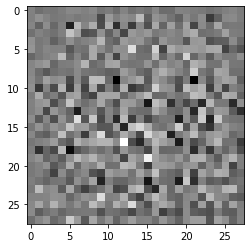

In [ ]:
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### **2.2 The Discriminator Model**

Our Discriminator architecture is essentially the reverse of the generator architecture. 

In this model
* There are 3 convolutional Layers
  * $1 × 28 × 28$
    * Leaky ReLU with slope 0.3
    * Dropout 0.3
  * $64 × 14 × 14$
    * Leaky ReLU with slope 0.3
    * Dropout 0.3
  * $128 × 7 × 7$
    * Leaky ReLU with slope 0.3
    * Dropout 0.3
* a dense layer that takes the flattened output of the last convolution and maps it to a scalar.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

## **3 Defining our Loss and Optimizers**

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### **3.1 Generator Loss**

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### **3.2 Discriminator Loss**

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## **4 Training Procedure**

### **4.1 Save Checkpoints**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### **Defining Training Loop**

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

generator_loss_historyE = []
discriminator_loss_historyE = []

generator_loss_history = []
discriminator_loss_history = []

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, count):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      generator_loss_history.append(gen_loss)
      discriminator_loss_history.append(disc_loss)
      
      if count == 235: # images per batch
        generator_loss_historyE.append(gen_loss)
        discriminator_loss_historyE.append(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    count = 0
    for image_batch in dataset:
      count += 1
      train_step(image_batch, count)

    # Produce images as we go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Epoch {} has completed in {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  #generate_and_save_images(generator,
  #                         epochs,
  #                         seed)

### **Generate and Save Images**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  
  
  if epoch in {10,30,50}:
    print ('\nDisplaying Intermediate Image for EPOCH {} '.format(epoch))  
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    print("\n")

### **Train our DCGAN**

Epoch 1 has completed in 16.599995613098145 sec
Epoch 2 has completed in 16.643548488616943 sec
Epoch 3 has completed in 16.6247136592865 sec
Epoch 4 has completed in 16.824407815933228 sec
Epoch 5 has completed in 16.973663568496704 sec
Epoch 6 has completed in 17.164094924926758 sec
Epoch 7 has completed in 17.003028392791748 sec
Epoch 8 has completed in 16.956988096237183 sec
Epoch 9 has completed in 16.993558645248413 sec

Displaying Intermediate Image for EPOCH 10 


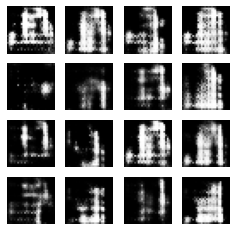



Epoch 10 has completed in 17.51514482498169 sec
Epoch 11 has completed in 17.098939180374146 sec
Epoch 12 has completed in 17.204435110092163 sec
Epoch 13 has completed in 17.121826887130737 sec
Epoch 14 has completed in 17.04276156425476 sec
Epoch 15 has completed in 17.4839768409729 sec
Epoch 16 has completed in 17.309478044509888 sec
Epoch 17 has completed in 17.412195444107056 sec
Epoch 18 has completed in 17.246619939804077 sec
Epoch 19 has completed in 17.238844394683838 sec
Epoch 20 has completed in 17.366016626358032 sec
Epoch 21 has completed in 17.243223428726196 sec
Epoch 22 has completed in 17.260968923568726 sec
Epoch 23 has completed in 17.231855869293213 sec
Epoch 24 has completed in 17.18539333343506 sec
Epoch 25 has completed in 17.29514479637146 sec
Epoch 26 has completed in 17.237709760665894 sec
Epoch 27 has completed in 17.319823265075684 sec
Epoch 28 has completed in 17.32664203643799 sec
Epoch 29 has completed in 17.301182985305786 sec

Displaying Intermediate 

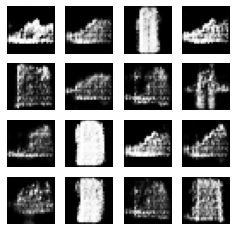



Epoch 30 has completed in 17.923434257507324 sec
Epoch 31 has completed in 17.30907392501831 sec
Epoch 32 has completed in 17.37797260284424 sec
Epoch 33 has completed in 17.279011487960815 sec
Epoch 34 has completed in 17.226465940475464 sec
Epoch 35 has completed in 17.290343523025513 sec
Epoch 36 has completed in 17.288508415222168 sec
Epoch 37 has completed in 17.255407571792603 sec
Epoch 38 has completed in 17.3572039604187 sec
Epoch 39 has completed in 17.34896731376648 sec
Epoch 40 has completed in 17.355344772338867 sec
Epoch 41 has completed in 17.24310851097107 sec
Epoch 42 has completed in 17.232586145401 sec
Epoch 43 has completed in 17.262603044509888 sec
Epoch 44 has completed in 17.333240509033203 sec
Epoch 45 has completed in 17.40606951713562 sec
Epoch 46 has completed in 17.313602685928345 sec
Epoch 47 has completed in 17.18541955947876 sec
Epoch 48 has completed in 17.249323844909668 sec
Epoch 49 has completed in 17.220914602279663 sec

Displaying Intermediate Imag

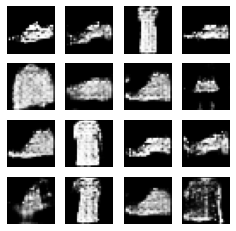



Epoch 50 has completed in 17.66970682144165 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
# Restore Latest Checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **5 Reporting Loss Curves**

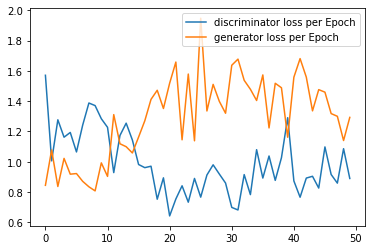

In [ ]:
plt.plot(discriminator_loss_historyE, label='discriminator loss per Epoch')
plt.plot(generator_loss_historyE, label='generator loss per Epoch')
plt.legend()
plt.show()

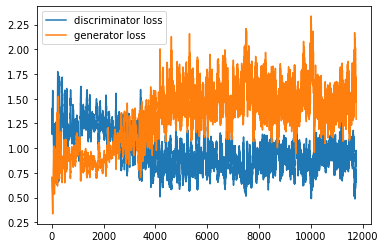

In [ ]:
plt.plot(discriminator_loss_history, label='discriminator loss')
plt.plot(generator_loss_history, label='generator loss')
plt.legend()
plt.show()

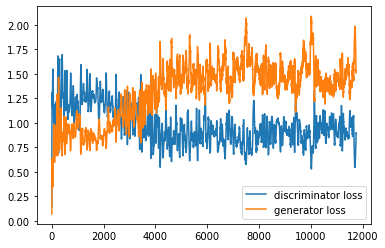

In [ ]:
from scipy.signal import lfilter

n = 10
b = [1.0 / n] * n
a = 1
disc_y = lfilter(b,a,discriminator_loss_history)
gen_y = lfilter(b,a,generator_loss_history)
plt.plot(disc_y, label='discriminator loss')
plt.plot(gen_y, label='generator loss')
plt.legend()
plt.show()


**Loss Behavior:** The discriminator loss seemed to be going down but the generator loss seemed to be increasing. However for the last quarter of all of the epochs, they seem to be leveling off together almost.

## **Resources**
* https://www.tensorflow.org/tutorials/generative/dcgan
* https://www.kaggle.com/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset
* https://github.com/anishreddy3/Fashion-MNIST-GAN-Keras/blob/master/fashion_MNIST_DCGAN.ipynb
* https://analyticsindiamag.com/hands-on-guide-to-deep-convolutional-gan-for-fashion-apparel-image-generation/